In [683]:
import pandas as pd

# Helpers
from data.data_builder import alfred_dataset, get_alfred
from models.models_builder import asset_arima, nowcaster, forecast_ma, forecast

import statsmodels.formula.api as smf
import statsmodels.api as sm

from statsmodels.tools.eval_measures import rmse
from epftoolbox.evaluation import GW

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

%reload_ext autoreload
%autoreload 2

# ***1 - Data***

### 1.1 - Alfred

In [684]:
indices = ["CPI", "CCPI", "FCPI", "GCPI"]
df = alfred_dataset(indices)
df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,688,1995-08-16 16:53:01.395348864,1967-01-01 00:00:00,1981-04-23 12:00:00,1995-08-16 12:00:00,2009-12-08 18:00:00,2024-04-01 00:00:00,NaN
CPI,688.0,151.966017,32.9,89.55,153.0,217.3655,313.207,76.740787
CCPI,688.0,156.092715,34.2,87.6,162.0,220.68225,317.622,78.315558
FCPI,688.0,153.538073,33.7,92.8,148.85,219.01,328.267,78.17727
GCPI,688.0,139.073121,26.1,80.4,102.1,211.595,411.984,90.836301


### 1.2 - News

In [685]:
df_news = pd.read_json('data/nowcaster/news_index.jsonl', lines=True)
df_news['date'] = pd.to_datetime(df_news['YearMonth'], unit="ms")
df_news = df_news[['date', 'polarity_score']]
df_news

,date,polarity_score
0,2010-01-01,0.001513
1,2010-02-01,5.986128
2,2010-03-01,0.710850
3,2010-04-01,3.805004
4,2010-05-01,-0.272589
...,...,...
163,2023-08-01,21.456362
164,2023-09-01,31.278293
165,2023-10-01,37.067493
166,2023-11-01,31.397521


In [686]:
df_news['roll_polarity'] = df_news['polarity_score'].rolling(window=12, min_periods=1).mean()

df_news['cum_polarity'] = df_news['polarity_score'].cumsum()
df_news['cum_roll_polarity'] = df_news['roll_polarity'].cumsum()

df_news

,date,polarity_score,roll_polarity,cum_polarity,cum_roll_polarity
0,2010-01-01,0.001513,0.001513,0.001513,0.001513
1,2010-02-01,5.986128,2.993821,5.987641,2.995334
2,2010-03-01,0.710850,2.232830,6.698491,5.228164
3,2010-04-01,3.805004,2.625874,10.503495,7.854038
4,2010-05-01,-0.272589,2.046181,10.230907,9.900219
...,...,...,...,...,...
163,2023-08-01,21.456362,21.132950,2186.842703,2124.095260
164,2023-09-01,31.278293,20.239009,2218.120996,2144.334270
165,2023-10-01,37.067493,20.505090,2255.188489,2164.839360
166,2023-11-01,31.397521,20.999736,2286.586010,2185.839096


In [687]:
NEWS_INDEX='cum_polarity'
df_news = df_news[['date', NEWS_INDEX]]
df_news = df_news.rename(columns={NEWS_INDEX: 'NEWS'})
df_news['NEWS'] = df_news['NEWS']+217.488
df_news

,date,NEWS
0,2010-01-01,217.489513
1,2010-02-01,223.475641
2,2010-03-01,224.186491
3,2010-04-01,227.991495
4,2010-05-01,227.718907
...,...,...
163,2023-08-01,2404.330703
164,2023-09-01,2435.608996
165,2023-10-01,2472.676489
166,2023-11-01,2504.074010


In [688]:
df = df.merge(df_news, on='date')
df

,date,CPI,CCPI,FCPI,GCPI,NEWS
0,2010-01-01,217.488,220.633,218.489,242.036,217.489513
1,2010-02-01,217.281,220.731,218.552,235.748,223.475641
2,2010-03-01,217.353,220.783,218.990,233.103,224.186491
3,2010-04-01,217.403,220.822,219.209,232.594,227.991495
4,2010-05-01,217.290,220.962,219.331,227.765,227.718907
...,...,...,...,...,...,...
163,2023-08-01,306.187,309.656,323.754,326.825,2404.330703
164,2023-09-01,307.288,310.644,324.356,332.019,2435.608996
165,2023-10-01,307.531,311.390,325.312,317.678,2472.676489
166,2023-11-01,308.024,312.349,325.870,304.982,2504.074010


### 1.3 - $\pi$-Computes

In [689]:
indices = [col for col in df.columns if col != 'date']
print(f'Regressors: {indices}')

Regressors: ['CPI', 'CCPI', 'FCPI', 'GCPI', 'NEWS']


In [690]:
pi_df = 100*df[indices].pct_change()
df[[f'pi-{i}' for i in indices]] = pi_df
df = df.dropna()
df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,167,2016-12-30 21:24:47.425149696,2010-02-01 00:00:00,2013-07-16 12:00:00,2017-01-01 00:00:00,2020-06-16 00:00:00,2023-12-01 00:00:00,NaN
CPI,167.0,250.070054,217.199,233.1965,243.618,259.076,308.742,24.326261
CCPI,167.0,254.361138,220.731,234.108,250.467,267.3875,313.209,25.125582
FCPI,167.0,256.75485,218.552,237.3175,248.735,268.7345,326.545,28.04721
GCPI,167.0,260.463503,160.74,220.8675,250.369,304.9415,411.984,51.548526
NEWS,167.0,620.008683,173.43576,241.955684,297.704494,467.502233,2504.07401,683.567959
pi-CPI,167.0,0.210382,-0.78404,0.060039,0.206228,0.327039,1.248288,0.270982
pi-CCPI,167.0,0.210153,-0.476283,0.123729,0.185767,0.239914,0.811903,0.162498
pi-FCPI,167.0,0.24129,-0.385036,0.087295,0.174585,0.302901,1.380187,0.277991
pi-GCPI,167.0,0.250679,-19.134667,-2.242814,0.509224,2.816054,14.874853,4.778488


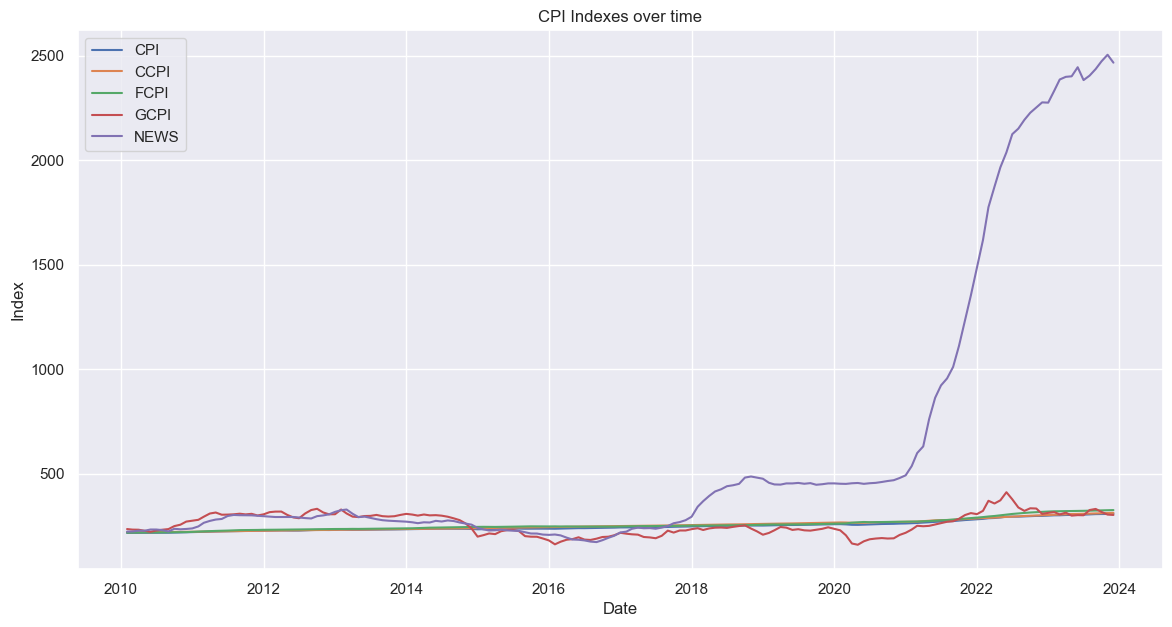

In [691]:
plt.figure(figsize=(14, 7))

# Plot each column on the same plot
for col in df.columns:
    if col != 'date' and not col.startswith('pi-'):
        plt.plot(df['date'], df[col], label=col)

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Index')
plt.title('Price Indices over time')
plt.legend(loc='best')  # Add a legend to differentiate columns

# Show the plot
plt.show()

In [693]:
# Load gasoline data
gasoline_df = pd.read_excel("data/nowcaster/2f. EMM_EPMR_PTE_NUS_DPGw.xls", sheet_name=1, header=2)
gasoline_df['Date'] = pd.to_datetime(gasoline_df['Date'])
gasoline_df = gasoline_df.rename(columns={'Date': 'date', 'Weekly U.S. Regular All Formulations Retail Gasoline Prices  (Dollars per Gallon)': 'GasolineNSA'})

# From weekly to monthly data
gasoline_df = gasoline_df.set_index('date').resample('M').mean().reset_index()
gasoline_df['date'] = gasoline_df['date'].dt.to_period('M').dt.to_timestamp()

gasoline_df['pi-GasolineNSA'] = 100*gasoline_df['GasolineNSA'].pct_change()
gasoline_df = gasoline_df.merge(df[['date', 'pi-GCPI']], on='date')

gasoline_df

,date,GasolineNSA,pi-GasolineNSA,pi-GCPI
0,2010-02-01,2.64400,-2.615101,-2.597961
1,2010-03-01,2.77160,4.826021,-1.121961
2,2010-04-01,2.84825,2.765551,-0.218358
3,2010-05-01,2.83620,-0.423067,-2.076150
4,2010-06-01,2.73150,-3.691559,-2.204026
...,...,...,...,...
162,2023-08-01,3.83975,6.748679,8.297657
163,2023-09-01,3.83600,-0.097663,1.589230
164,2023-10-01,3.61280,-5.818561,-4.319331
165,2023-11-01,3.31800,-8.159876,-3.996500


In [694]:
gasoline_df['diff'] = gasoline_df['pi-GasolineNSA'] - gasoline_df['pi-GCPI']
gasoline_df

,date,GasolineNSA,pi-GasolineNSA,pi-GCPI,diff
0,2010-02-01,2.64400,-2.615101,-2.597961,-0.017141
1,2010-03-01,2.77160,4.826021,-1.121961,5.947982
2,2010-04-01,2.84825,2.765551,-0.218358,2.983909
3,2010-05-01,2.83620,-0.423067,-2.076150,1.653083
4,2010-06-01,2.73150,-3.691559,-2.204026,-1.487533
...,...,...,...,...,...
162,2023-08-01,3.83975,6.748679,8.297657,-1.548977
163,2023-09-01,3.83600,-0.097663,1.589230,-1.686892
164,2023-10-01,3.61280,-5.818561,-4.319331,-1.499230
165,2023-11-01,3.31800,-8.159876,-3.996500,-4.163376


In [695]:
import numpy as np

gasoline_df['sf'] = [np.mean([gasoline_df['diff'].iloc[i - (j*12)] for j in range(1, 4)]) if i>48 else gasoline_df['diff'].iloc[i] for i in gasoline_df.index]
gasoline_df

,date,GasolineNSA,pi-GasolineNSA,pi-GCPI,diff,sf
0,2010-02-01,2.64400,-2.615101,-2.597961,-0.017141,-0.017141
1,2010-03-01,2.77160,4.826021,-1.121961,5.947982,5.947982
2,2010-04-01,2.84825,2.765551,-0.218358,2.983909,2.983909
3,2010-05-01,2.83620,-0.423067,-2.076150,1.653083,1.653083
4,2010-06-01,2.73150,-3.691559,-2.204026,-1.487533,-1.487533
...,...,...,...,...,...,...
162,2023-08-01,3.83975,6.748679,8.297657,-1.548977,-2.103769
163,2023-09-01,3.83600,-0.097663,1.589230,-1.686892,-1.222521
164,2023-10-01,3.61280,-5.818561,-4.319331,-1.499230,-0.456058
165,2023-11-01,3.31800,-8.159876,-3.996500,-4.163376,-2.990474


In [696]:
gasoline_df['pi-Gasoline'] = gasoline_df['pi-GasolineNSA'] - gasoline_df['sf']
gasoline_df

,date,GasolineNSA,pi-GasolineNSA,pi-GCPI,diff,sf,pi-Gasoline
0,2010-02-01,2.64400,-2.615101,-2.597961,-0.017141,-0.017141,-2.597961
1,2010-03-01,2.77160,4.826021,-1.121961,5.947982,5.947982,-1.121961
2,2010-04-01,2.84825,2.765551,-0.218358,2.983909,2.983909,-0.218358
3,2010-05-01,2.83620,-0.423067,-2.076150,1.653083,1.653083,-2.076150
4,2010-06-01,2.73150,-3.691559,-2.204026,-1.487533,-1.487533,-2.204026
...,...,...,...,...,...,...,...
162,2023-08-01,3.83975,6.748679,8.297657,-1.548977,-2.103769,8.852449
163,2023-09-01,3.83600,-0.097663,1.589230,-1.686892,-1.222521,1.124859
164,2023-10-01,3.61280,-5.818561,-4.319331,-1.499230,-0.456058,-5.362503
165,2023-11-01,3.31800,-8.159876,-3.996500,-4.163376,-2.990474,-5.169402


In [697]:
df = df.merge(gasoline_df[['date', 'pi-Gasoline']], on='date')
df = df.dropna()
df

,date,CPI,CCPI,FCPI,GCPI,NEWS,pi-CPI,pi-CCPI,pi-FCPI,pi-GCPI,pi-NEWS,pi-Gasoline
0,2010-02-01,217.281,220.731,218.552,235.748,223.475641,-0.095178,0.044418,0.028834,-2.597961,2.752376,-2.597961
1,2010-03-01,217.353,220.783,218.990,233.103,224.186491,0.033137,0.023558,0.200410,-1.121961,0.318088,-1.121961
2,2010-04-01,217.403,220.822,219.209,232.594,227.991495,0.023004,0.017664,0.100005,-0.218358,1.697249,-0.218358
3,2010-05-01,217.290,220.962,219.331,227.765,227.718907,-0.051977,0.063399,0.055655,-2.076150,-0.119561,-2.076150
4,2010-06-01,217.199,221.194,219.285,222.745,233.585475,-0.041880,0.104995,-0.020973,-2.204026,2.576233,-2.204026
...,...,...,...,...,...,...,...,...,...,...,...,...
162,2023-08-01,306.187,309.656,323.754,326.825,2404.330703,0.511772,0.230138,0.243057,8.297657,0.900440,8.852449
163,2023-09-01,307.288,310.644,324.356,332.019,2435.608996,0.359584,0.319064,0.185944,1.589230,1.300915,1.124859
164,2023-10-01,307.531,311.390,325.312,317.678,2472.676489,0.079079,0.240146,0.294738,-4.319331,1.521898,-5.362503
165,2023-11-01,308.024,312.349,325.870,304.982,2504.074010,0.160309,0.307974,0.171528,-3.996500,1.269779,-5.169402


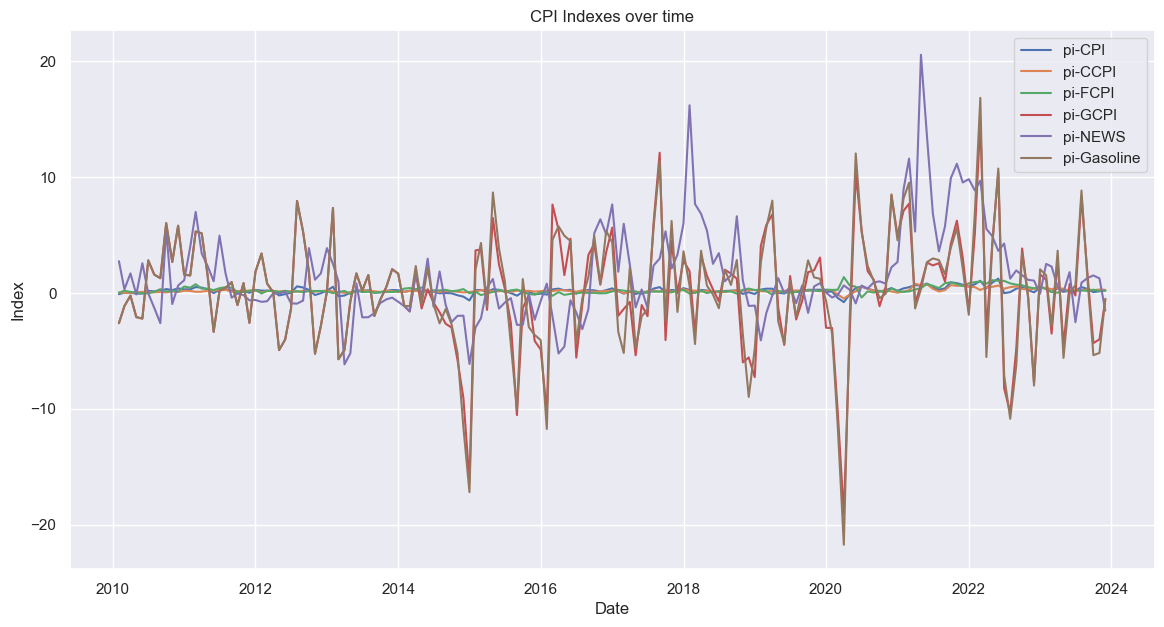

In [698]:
plt.figure(figsize=(14, 7))

# Plot each column on the same plot
for col in df.columns:
    if col != 'date' and col.startswith('pi'):
        plt.plot(df['date'], df[col], label=col)

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Index')
plt.title('CPI Indexes over time')
plt.legend(loc='best')  # Add a legend to differentiate columns

# Show the plot
plt.show()

# ***2 - Models***

In [699]:
models = {}

In [700]:
# Train/Test datesplit
train_start = pd.to_datetime("2015-01-01")
train_end = pd.to_datetime("2020-01-01")
train_range = pd.date_range(train_start, train_end, freq="MS", inclusive="left")

test_start = pd.to_datetime("2020-01-01")
test_end = pd.to_datetime("2024-01-01")
test_range = pd.date_range(test_start, test_end, freq="MS", inclusive="left")

In [701]:
ycol = "pi-CPI"

### 2.0 - Baseline: *FED*

In [702]:
xcols_fed = ["pi-CCPI", "pi-FCPI", "pi-Gasoline"]

# Build nowcaster
model_fed = nowcaster(df, xcols_fed, ycol, train_range)

                            OLS Regression Results                            
Dep. Variable:                 pi-CPI   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     153.6
Date:                Tue, 28 May 2024   Prob (F-statistic):           5.41e-27
Time:                        19:44:50   Log-Likelihood:                 82.086
No. Observations:                  60   AIC:                            -156.2
Df Residuals:                      56   BIC:                            -147.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0215      0.026      0.842      

In [703]:
models.update({'fed': {'xcols': xcols_fed, 'model': model_fed}})

### 2.1 - *News Index*

In [704]:
xcols_news = ["pi-NEWS"]

# Build nowcaster
model_news = nowcaster(df, xcols_news, ycol, train_range)

                            OLS Regression Results                            
Dep. Variable:                 pi-CPI   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     3.757
Date:                Tue, 28 May 2024   Prob (F-statistic):             0.0575
Time:                        19:44:52   Log-Likelihood:                 17.298
No. Observations:                  60   AIC:                            -30.60
Df Residuals:                      58   BIC:                            -26.41
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1387      0.025      5.625      0.0

In [705]:
models.update({'news': {'xcols': xcols_news, 'model': model_news}})

### 2.2 - *Fed + News*

In [706]:
xcols_fednews = ["pi-CCPI", "pi-FCPI", "pi-Gasoline", "pi-NEWS"]

# Build nowcaster
model_fednews = nowcaster(df, xcols_fednews, ycol, train_range)

                            OLS Regression Results                            
Dep. Variable:                 pi-CPI   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     123.0
Date:                Tue, 28 May 2024   Prob (F-statistic):           9.52e-27
Time:                        19:44:54   Log-Likelihood:                 84.321
No. Observations:                  60   AIC:                            -158.6
Df Residuals:                      55   BIC:                            -148.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0174      0.025      0.698      

In [707]:
models.update({'fed+news': {'xcols': xcols_fednews, 'model': model_fednews}})

### 2.3 *FED-GAS+NEWS*

In [708]:
xcols_fedgasnews = ["pi-CCPI", "pi-FCPI", "pi-NEWS"]

# Build nowcaster
model_fedgasnews = nowcaster(df, xcols_fedgasnews, ycol, train_range)

                            OLS Regression Results                            
Dep. Variable:                 pi-CPI   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     2.705
Date:                Tue, 28 May 2024   Prob (F-statistic):             0.0540
Time:                        19:44:55   Log-Likelihood:                 19.474
No. Observations:                  60   AIC:                            -30.95
Df Residuals:                      56   BIC:                            -22.57
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0137      0.073      0.188      0.8

In [709]:
models.update({'fed-gas+news': {'xcols': xcols_fedgasnews, 'model': model_fedgasnews}})

### 2.4 - *CCPI+NEWS*

In [710]:
xcols_ccpinews = ["pi-CCPI", "pi-NEWS"]

# Build nowcaster
model_ccpinews = nowcaster(df, xcols_ccpinews, ycol, train_range)

                            OLS Regression Results                            
Dep. Variable:                 pi-CPI   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     3.982
Date:                Tue, 28 May 2024   Prob (F-statistic):             0.0241
Time:                        19:44:57   Log-Likelihood:                 19.339
No. Observations:                  60   AIC:                            -32.68
Df Residuals:                      57   BIC:                            -26.39
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0058      0.071      0.083      0.9

# 3 - ***Evaluations***

### 3.1 - *Forcasting*

In [711]:
from functools import reduce

yh = []

#for t in pd.date_range(test_start, test_end, freq="MS", inclusive="left"):
for name, d in models.items():
    model_forecast = forecast(df, d['model'], d['xcols'], ycol, test_range[0], len(test_range))
    model_forecast = model_forecast.rename(columns={'forecast': name})
    yh.append(model_forecast)

yh.append(df[['date', ycol]].rename(columns={ycol: 'realized'}))

forecasts_df = reduce(lambda x, y: x.merge(y, on='date'), yh)

#forecasts_df['realized'] = (forecasts_df['realized'] + 1)**12 - 1

forecasts_df.head()

,date,fed,news,fed+news,fed-gas+news,realized
0,2020-01-01,0.192777,0.132886,0.185484,0.139011,0.106716
1,2020-02-01,0.204563,0.134016,0.197455,0.138836,0.131322
2,2020-03-01,0.191829,0.137752,0.186399,0.149183,-0.422764
3,2020-04-01,0.130058,0.139337,0.125982,0.132630,-0.784040
4,2020-05-01,0.034638,0.140194,0.031620,0.081434,-0.108540


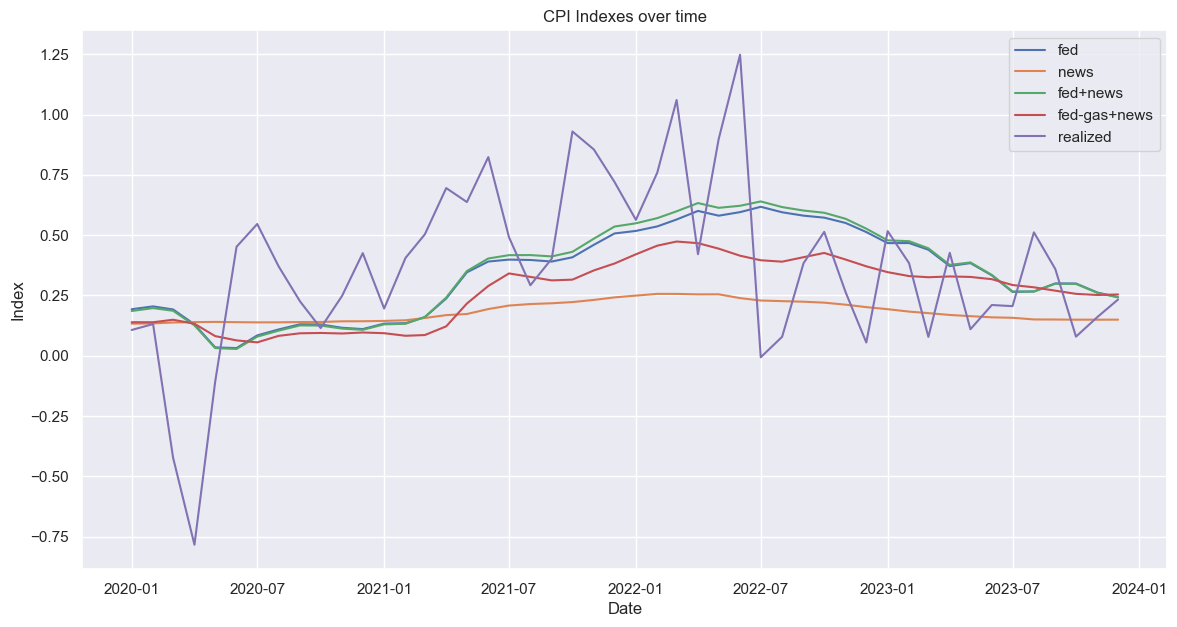

In [712]:
plt.figure(figsize=(14, 7))

# Plot each column on the same plot
for col in forecasts_df.columns:
    if col != 'date':
        plt.plot(forecasts_df['date'], forecasts_df[col], label=col)

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Index')
plt.title('CPI Indexes over time')
plt.legend(loc='best')  # Add a legend to differentiate columns

# Show the plot
plt.show()

### 3.2 - *Scores*

In [713]:
baseline = 'fed'

In [714]:
def GW_adapter(forecasts):
    return np.repeat(forecasts.to_numpy()[:, np.newaxis], 24, axis=1)

res = []

for name, model in models.items():
    # Computing Scores
    rmse_v = rmse(forecasts_df[name], forecasts_df['realized'])
    gw = GW(GW_adapter(forecasts_df['realized']), GW_adapter(forecasts_df[baseline]), GW_adapter(forecasts_df[name]), version='multivariate')

    # Adding to the df
    res.append({'model': name, 'rmse': rmse_v, 'gw': gw})
    # print(f"{'-'*10} {name.upper()} {'-'*10}")
    # print(f"RMSE: {rmse}")
    # print(f"Giacomini-White: {gw}")

# Creating the df
res_df = pd.DataFrame(res)
res_df

,model,rmse,gw
0,fed,0.329463,1.000000
1,news,0.383391,1.000000
2,fed+news,0.327270,0.315723
3,fed-gas+news,0.344652,1.000000
